In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [14]:
class OverlapPatchEmbed(nn.Module):
    """Overlapping Patch Embedding used in SegFormer"""
    def __init__(self, patch_size=7, stride=4, in_channels=3, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, 
                              stride=stride, padding=patch_size // 2)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x, H, W

class EfficientSelfAttention(nn.Module):
    """Efficient Self-Attention with Sequence Reduction"""
    def __init__(self, embed_dim=768, num_heads=12, sr_ratio=1, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.sr_ratio = sr_ratio
        
        self.q = nn.Linear(embed_dim, embed_dim)
        self.kv = nn.Linear(embed_dim, embed_dim * 2)
        
        if sr_ratio > 1:
            self.sr = nn.Conv2d(embed_dim, embed_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(embed_dim)
        
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, H, W):
        B, N, C = x.shape
        
        q = self.q(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, N, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        
        k, v = kv[0], kv[1]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim=768, mlp_ratio=4, dropout_rate=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.dwconv = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, 
                                padding=1, groups=hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, H, W):
        B, N, C = x.shape
        x = self.fc1(x)
        
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)
        
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, sr_ratio=1, dropout_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = EfficientSelfAttention(embed_dim, num_heads, sr_ratio, dropout_rate)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout_rate)
        
    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x), H, W)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class FeatureFusion(nn.Module):
    def __init__(self, channels, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
            
        self.fusion_conv = nn.Sequential(*layers)
        
    def forward(self, f1, f2):
        fused = torch.cat([f1, f2], dim=1)
        return self.fusion_conv(fused)

class MLP_Decoder(nn.Module):
    """All-MLP Decoder Head for SegFormer"""
    def __init__(self, in_channels=[32, 64, 128, 256], embed_dim=256, num_classes=1):
        super().__init__()
        
        self.linear_c4 = nn.Linear(in_channels[3], embed_dim)
        self.linear_c3 = nn.Linear(in_channels[2], embed_dim)
        self.linear_c2 = nn.Linear(in_channels[1], embed_dim)
        self.linear_c1 = nn.Linear(in_channels[0], embed_dim)
        
        self.linear_fuse = nn.Sequential(
            nn.Conv2d(embed_dim * 4, embed_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )
        
        self.linear_pred = nn.Conv2d(embed_dim, num_classes, kernel_size=1)
        
    def forward(self, features):
        c1, c2, c3, c4 = features
        
        B, N, C = c4.shape
        H4, W4 = int(N ** 0.5), int(N ** 0.5)
        
        _c4 = self.linear_c4(c4).permute(0, 2, 1).reshape(B, -1, H4, W4)
        _c4 = F.interpolate(_c4, size=c1.shape[2:4] if len(c1.shape) == 4 else (int(c1.shape[1] ** 0.5), int(c1.shape[1] ** 0.5)), 
                           mode='bilinear', align_corners=False)
        
        _c3 = self.linear_c3(c3).permute(0, 2, 1).reshape(B, -1, int(c3.shape[1] ** 0.5), int(c3.shape[1] ** 0.5))
        _c3 = F.interpolate(_c3, size=_c4.shape[2:], mode='bilinear', align_corners=False)
        
        _c2 = self.linear_c2(c2).permute(0, 2, 1).reshape(B, -1, int(c2.shape[1] ** 0.5), int(c2.shape[1] ** 0.5))
        _c2 = F.interpolate(_c2, size=_c4.shape[2:], mode='bilinear', align_corners=False)
        
        _c1 = self.linear_c1(c1).permute(0, 2, 1).reshape(B, -1, int(c1.shape[1] ** 0.5), int(c1.shape[1] ** 0.5))
        _c1 = F.interpolate(_c1, size=_c4.shape[2:], mode='bilinear', align_corners=False)
        
        _c = torch.cat([_c4, _c3, _c2, _c1], dim=1)
        _c = self.linear_fuse(_c)
        
        x = self.linear_pred(_c)
        
        return x

class SegFormer(nn.Module):
    def __init__(self, img_size=256, in_channels=3, out_channels=1,
                 embed_dims=[32, 64, 128, 256], num_heads=[1, 2, 4, 8], 
                 mlp_ratios=[4, 4, 4, 4], sr_ratios=[8, 4, 2, 1],
                 num_layers=6, dropout_rate=0.15,
                 features=[32, 64, 128, 256]):
        super().__init__()
        
        self.img_size = img_size
        self.features = features
        
        # Calculate layers per stage (6 total layers distributed across 4 stages)
        # Stage distribution: [1, 1, 2, 2] to match 6 total layers
        self.depths = [1, 1, 2, 2]
        
        # Patch embeddings for each stage (adjusted to match CNN encoder dimensions)
        # Stage 1: 256 -> 64 (stride 4)
        self.patch_embed1 = OverlapPatchEmbed(patch_size=7, stride=4, in_channels=in_channels, 
                                              embed_dim=embed_dims[0])
        # Stage 2: 64 -> 32 (stride 2)
        self.patch_embed2 = OverlapPatchEmbed(patch_size=3, stride=2, in_channels=embed_dims[0], 
                                              embed_dim=embed_dims[1])
        # Stage 3: 32 -> 16 (stride 2)
        self.patch_embed3 = OverlapPatchEmbed(patch_size=3, stride=2, in_channels=embed_dims[1], 
                                              embed_dim=embed_dims[2])
        # Stage 4: 16 -> 8 (stride 2)
        self.patch_embed4 = OverlapPatchEmbed(patch_size=3, stride=2, in_channels=embed_dims[2], 
                                              embed_dim=embed_dims[3])
        
        # Transformer blocks for each stage
        self.block1 = nn.ModuleList([TransformerBlock(
            embed_dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], 
            sr_ratio=sr_ratios[0], dropout_rate=dropout_rate
        ) for _ in range(self.depths[0])])
        
        self.block2 = nn.ModuleList([TransformerBlock(
            embed_dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1],
            sr_ratio=sr_ratios[1], dropout_rate=dropout_rate
        ) for _ in range(self.depths[1])])
        
        self.block3 = nn.ModuleList([TransformerBlock(
            embed_dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2],
            sr_ratio=sr_ratios[2], dropout_rate=dropout_rate
        ) for _ in range(self.depths[2])])
        
        self.block4 = nn.ModuleList([TransformerBlock(
            embed_dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3],
            sr_ratio=sr_ratios[3], dropout_rate=dropout_rate
        ) for _ in range(self.depths[3])])
        
        # Norms for each stage
        self.norm1 = nn.LayerNorm(embed_dims[0])
        self.norm2 = nn.LayerNorm(embed_dims[1])
        self.norm3 = nn.LayerNorm(embed_dims[2])
        self.norm4 = nn.LayerNorm(embed_dims[3])
        
        # Feature fusion modules
        self.fusion1 = FeatureFusion(features[0], dropout_rate, use_dropout=False)
        self.fusion2 = FeatureFusion(features[1], dropout_rate, use_dropout=False)
        self.fusion3 = FeatureFusion(features[2], dropout_rate, use_dropout=False)
        self.fusion4 = FeatureFusion(features[3], dropout_rate=0.1, use_dropout=True)
        
        # CNN encoder for skip connections (same as BEiT)
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate, use_dropout=False)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate, use_dropout=False)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate, use_dropout=False)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate, use_dropout=False)
        
        # Decoder (using CNN-based decoder like BEiT)
        # Transformer output needs to match CNN encoder resolution (32x32 for fused_e4)
        self.decode_proj = nn.Linear(embed_dims[3] * 2, features[3] * 2)
        # Upsample from 8x8 to 32x32 (4x upsampling)
        self.upsample_to_cnn = nn.Sequential(
            nn.ConvTranspose2d(features[3] * 2, features[3] * 2, kernel_size=4, stride=4),
            nn.BatchNorm2d(features[3] * 2),
            nn.ReLU(inplace=True)
        )
        
        # Now decoder starts from 32x32 and goes to 256x256
        self.dec4 = DoubleConv(features[3] * 3, features[3], dropout_rate, use_dropout=True)
        
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2], dropout_rate, use_dropout=True)
        
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1], dropout_rate, use_dropout=True)
        
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0], dropout_rate, use_dropout=True)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward_features(self, x):
        B = x.shape[0]
        outs = []
        
        # Stage 1
        x, H, W = self.patch_embed1(x)
        for blk in self.block1:
            x = blk(x, H, W)
        x = self.norm1(x)
        outs.append(x)
        
        # Stage 2
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)
        x, H, W = self.patch_embed2(x)
        for blk in self.block2:
            x = blk(x, H, W)
        x = self.norm2(x)
        outs.append(x)
        
        # Stage 3
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)
        x, H, W = self.patch_embed3(x)
        for blk in self.block3:
            x = blk(x, H, W)
        x = self.norm3(x)
        outs.append(x)
        
        # Stage 4
        x = x.permute(0, 2, 1).reshape(B, -1, H, W)
        x, H, W = self.patch_embed4(x)
        for blk in self.block4:
            x = blk(x, H, W)
        x = self.norm4(x)
        outs.append(x)
        
        return outs[-1]  # Return only the last stage for decoder
    
    def forward(self, x):
        pre_img = x[:, :3, :, :]
        post_img = x[:, 3:, :, :]
        
        # CNN encoder for skip connections
        pre_e1 = self.enc1(pre_img)
        pre_p1 = self.pool1(pre_e1)
        
        pre_e2 = self.enc2(pre_p1)
        pre_p2 = self.pool2(pre_e2)
        
        pre_e3 = self.enc3(pre_p2)
        pre_p3 = self.pool3(pre_e3)
        
        pre_e4 = self.enc4(pre_p3)
        
        post_e1 = self.enc1(post_img)
        post_p1 = self.pool1(post_e1)
        
        post_e2 = self.enc2(post_p1)
        post_p2 = self.pool2(post_e2)
        
        post_e3 = self.enc3(post_p2)
        post_p3 = self.pool3(post_e3)
        
        post_e4 = self.enc4(post_p3)
        
        # Fuse CNN features
        fused_e1 = self.fusion1(pre_e1, post_e1)
        fused_e2 = self.fusion2(pre_e2, post_e2)
        fused_e3 = self.fusion3(pre_e3, post_e3)
        fused_e4 = self.fusion4(pre_e4, post_e4)
        
        # SegFormer transformer features
        pre_transformer_features = self.forward_features(pre_img)
        post_transformer_features = self.forward_features(post_img)
        
        # Combine transformer features
        combined_features = torch.cat([pre_transformer_features, post_transformer_features], dim=-1)
        
        B, N, C = combined_features.shape
        patch_h = patch_w = int(N ** 0.5)
        
        combined_features = self.decode_proj(combined_features)
        combined_features = combined_features.transpose(1, 2).reshape(B, -1, patch_h, patch_w)
        
        # Upsample transformer features from 8x8 to 32x32 to match CNN encoder resolution
        combined_features = self.upsample_to_cnn(combined_features)
        
        # Decoder with skip connections - concatenate at 32x32 resolution
        d4 = torch.cat([combined_features, fused_e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, fused_e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, fused_e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, fused_e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.final_conv(d1)
        return out

In [15]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        
        label = (label > 0.5).float()
        
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

In [16]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

In [17]:
def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    if scheduler is not None:
        scheduler.step()
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, patience=15):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_segformer_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

In [18]:
def main():
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    model = SegFormer(img_size=256, in_channels=3, out_channels=1,
                     embed_dims=[32, 64, 128, 256], num_heads=[1, 2, 4, 8],
                     mlp_ratios=[4, 4, 4, 4], sr_ratios=[8, 4, 2, 1],
                     num_layers=6, dropout_rate=0.15,
                     features=[32, 64, 128, 256]).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("Starting SegFormer training...")
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332
Total parameters: 13,044,193
Starting SegFormer training...

Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:14<00:00, 11.20it/s]


Train Loss: 0.598221 | Train Acc: 0.9173
Val Loss: 0.561657 | Val Acc: 0.8608 | IoU: 0.1635 | Dice: 0.2810 | F1: 0.2810
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.561657

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.08it/s]


Train Loss: 0.476860 | Train Acc: 0.9344
Val Loss: 0.420621 | Val Acc: 0.9394 | IoU: 0.3522 | Dice: 0.5210 | F1: 0.5210
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.420621

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.46it/s]


Train Loss: 0.430595 | Train Acc: 0.9384
Val Loss: 0.411239 | Val Acc: 0.9534 | IoU: 0.3353 | Dice: 0.5022 | F1: 0.5022
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.411239

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.40it/s]


Train Loss: 0.409428 | Train Acc: 0.9423
Val Loss: 0.390703 | Val Acc: 0.9507 | IoU: 0.3949 | Dice: 0.5662 | F1: 0.5662
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.390703

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.06it/s]


Train Loss: 0.396261 | Train Acc: 0.9460
Val Loss: 0.389310 | Val Acc: 0.9528 | IoU: 0.3859 | Dice: 0.5569 | F1: 0.5569
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.389310

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.54it/s]


Train Loss: 0.384380 | Train Acc: 0.9490
Val Loss: 0.390567 | Val Acc: 0.9335 | IoU: 0.3801 | Dice: 0.5508 | F1: 0.5508
Learning Rate: 2.00e-04

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.37it/s]


Train Loss: 0.376658 | Train Acc: 0.9514
Val Loss: 0.389480 | Val Acc: 0.9474 | IoU: 0.4189 | Dice: 0.5905 | F1: 0.5905
Learning Rate: 2.00e-04

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.15it/s]


Train Loss: 0.368234 | Train Acc: 0.9542
Val Loss: 0.384911 | Val Acc: 0.9553 | IoU: 0.4169 | Dice: 0.5884 | F1: 0.5884
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.384911

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.27it/s]


Train Loss: 0.361129 | Train Acc: 0.9556
Val Loss: 0.378717 | Val Acc: 0.9491 | IoU: 0.4344 | Dice: 0.6057 | F1: 0.6057
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.378717

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.07it/s]


Train Loss: 0.351699 | Train Acc: 0.9586
Val Loss: 0.376157 | Val Acc: 0.9559 | IoU: 0.4353 | Dice: 0.6066 | F1: 0.6066
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.376157

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.27it/s]


Train Loss: 0.343073 | Train Acc: 0.9607
Val Loss: 0.374795 | Val Acc: 0.9537 | IoU: 0.4428 | Dice: 0.6138 | F1: 0.6138
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.374795

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.45it/s]


Train Loss: 0.335999 | Train Acc: 0.9629
Val Loss: 0.390933 | Val Acc: 0.9401 | IoU: 0.3965 | Dice: 0.5678 | F1: 0.5678
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.47it/s]


Train Loss: 0.330770 | Train Acc: 0.9634
Val Loss: 0.376784 | Val Acc: 0.9498 | IoU: 0.4428 | Dice: 0.6138 | F1: 0.6138
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.99it/s]


Train Loss: 0.320430 | Train Acc: 0.9670
Val Loss: 0.383112 | Val Acc: 0.9571 | IoU: 0.4407 | Dice: 0.6118 | F1: 0.6118
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.92it/s]


Train Loss: 0.315297 | Train Acc: 0.9682
Val Loss: 0.390584 | Val Acc: 0.9546 | IoU: 0.4317 | Dice: 0.6030 | F1: 0.6030
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.73it/s]


Train Loss: 0.308854 | Train Acc: 0.9700
Val Loss: 0.373698 | Val Acc: 0.9533 | IoU: 0.4476 | Dice: 0.6184 | F1: 0.6184
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.373698

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.75it/s]


Train Loss: 0.301348 | Train Acc: 0.9718
Val Loss: 0.397975 | Val Acc: 0.9410 | IoU: 0.4133 | Dice: 0.5848 | F1: 0.5848
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.57it/s]


Train Loss: 0.294943 | Train Acc: 0.9734
Val Loss: 0.395249 | Val Acc: 0.9470 | IoU: 0.4308 | Dice: 0.6022 | F1: 0.6022
Learning Rate: 2.00e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.74it/s]


Train Loss: 0.289653 | Train Acc: 0.9747
Val Loss: 0.386279 | Val Acc: 0.9508 | IoU: 0.4459 | Dice: 0.6168 | F1: 0.6168
Learning Rate: 2.00e-04

Epoch 20/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.03it/s]


Train Loss: 0.282001 | Train Acc: 0.9765
Val Loss: 0.398385 | Val Acc: 0.9556 | IoU: 0.4324 | Dice: 0.6038 | F1: 0.6038
Learning Rate: 2.00e-04

Epoch 21/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.96it/s]


Train Loss: 0.278976 | Train Acc: 0.9773
Val Loss: 0.399404 | Val Acc: 0.9438 | IoU: 0.4302 | Dice: 0.6016 | F1: 0.6016
Learning Rate: 2.00e-04

Epoch 22/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.64it/s]


Train Loss: 0.275132 | Train Acc: 0.9784
Val Loss: 0.386020 | Val Acc: 0.9547 | IoU: 0.4591 | Dice: 0.6293 | F1: 0.6293
Learning Rate: 2.00e-04

Epoch 23/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.02it/s]


Train Loss: 0.267846 | Train Acc: 0.9801
Val Loss: 0.388822 | Val Acc: 0.9495 | IoU: 0.4423 | Dice: 0.6134 | F1: 0.6134
Learning Rate: 2.00e-04

Epoch 24/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.51it/s]


Train Loss: 0.266787 | Train Acc: 0.9802
Val Loss: 0.401573 | Val Acc: 0.9575 | IoU: 0.4574 | Dice: 0.6277 | F1: 0.6277
Learning Rate: 1.40e-04

Epoch 25/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.52it/s]


Train Loss: 0.253257 | Train Acc: 0.9832
Val Loss: 0.397461 | Val Acc: 0.9559 | IoU: 0.4472 | Dice: 0.6180 | F1: 0.6180
Learning Rate: 1.40e-04

Epoch 26/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.89it/s]

Train Loss: 0.246781 | Train Acc: 0.9847
Val Loss: 0.401217 | Val Acc: 0.9554 | IoU: 0.4604 | Dice: 0.6305 | F1: 0.6305
Learning Rate: 1.40e-04
Early stopping triggered after 26 epochs


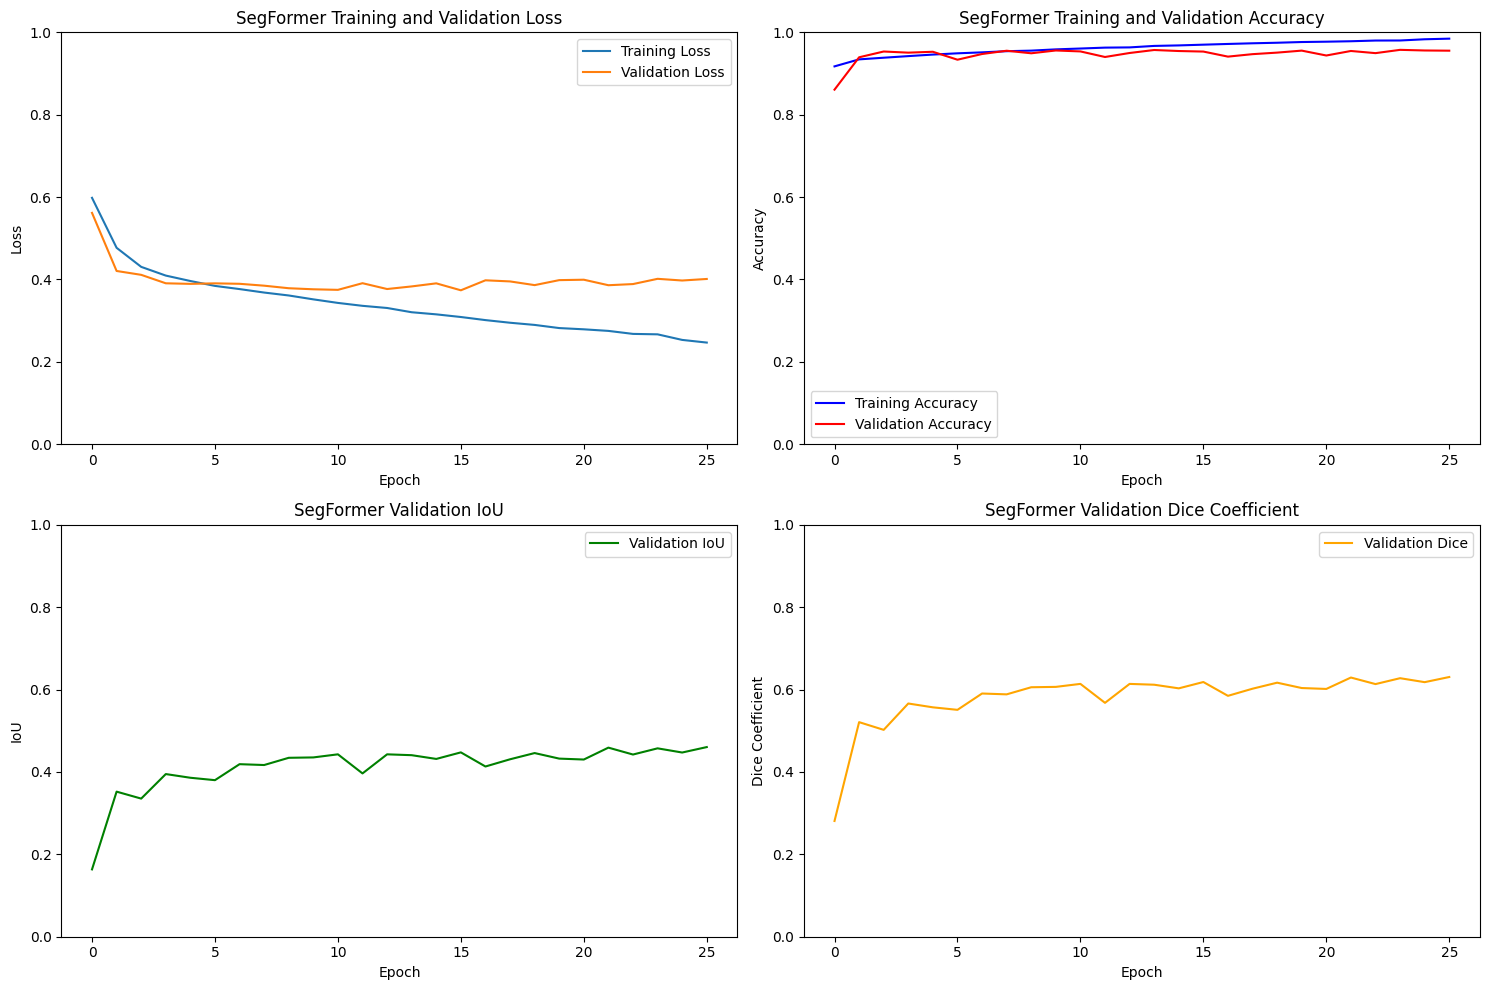

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('SegFormer Training and Validation Loss')

ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('SegFormer Training and Validation Accuracy')

ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('SegFormer Validation IoU')

ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('SegFormer Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('segformer_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Loading best SegFormer model for test evaluation...

Evaluating SegFormer on test set...


Val batch: 100%|██████████| 332/332 [00:17<00:00, 19.10it/s]



SEGFORMER TEST EVALUATION METRICS
Test set processed with batch_size=1
Loss:            0.379723
IoU:             0.4456
mIoU:            0.6989
Dice Coefficient: 0.6165
Accuracy:        0.9540
Precision:       0.6098
Recall:          0.6233
F1-Score:        0.6165
Confusion matrix (pixel-level):
[[19951134   515107]
 [  486592   805119]]


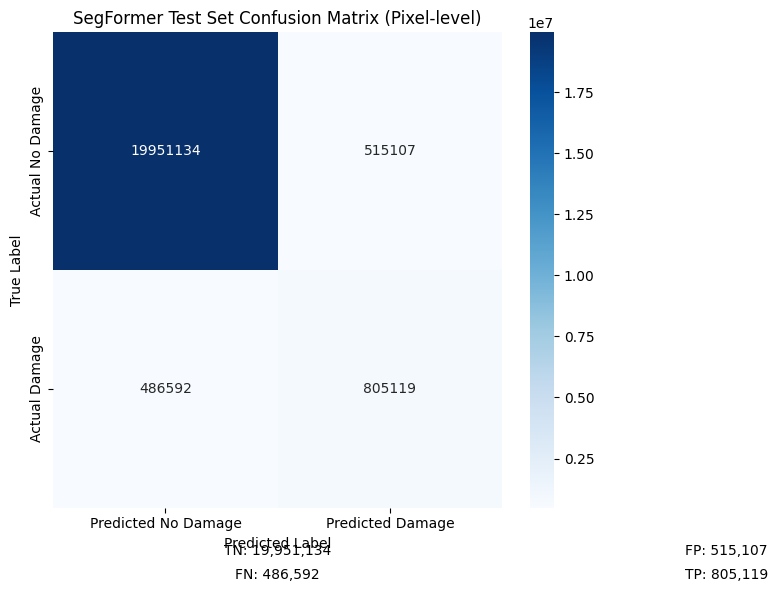

SegFormer training and evaluation completed!


In [20]:
print("Loading best SegFormer model for test evaluation...")
model.load_state_dict(torch.load('best_segformer_earthquake.pth', map_location=device))
model.to(device)

print("\nEvaluating SegFormer on test set...")
test_metrics = validate(model, test_loader)

print("\n" + "="*50)
print("SEGFORMER TEST EVALUATION METRICS")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Damage', 'Predicted Damage'],
            yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('SegFormer Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('segformer_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("SegFormer training and evaluation completed!")